# ML final project
## 張皓丞 10811017



In [651]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import tqdm
from sklearn.preprocessing import minmax_scale
from scipy import stats
from collections import Counter
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,f1_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from text_preprocessing import preprocess_text
from text_preprocessing import to_lower, remove_itemized_bullet_and_numbering, remove_punctuation, remove_whitespace, normalize_unicode,remove_stopword, substitute_token,lemmatize_word
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package omw-1.4 to /Users/chc/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Import the dataset and explore them

In [687]:
dataX = pd.read_excel("MLdata/Dataset1_train/X_train.xlsx")
dataY = pd.read_excel("MLdata/Dataset1_train/y_train.xlsx")

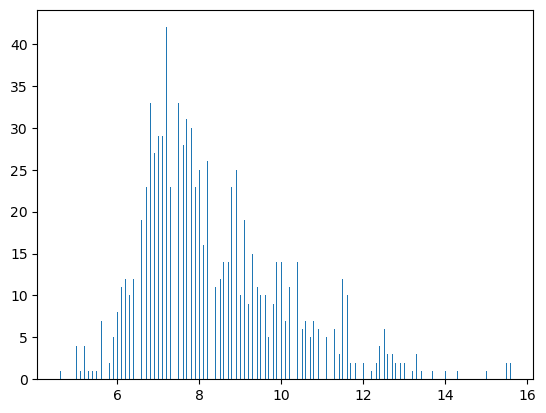

In [27]:
plt.hist(dataX[dataX.columns[0]],bins=500)
plt.show()

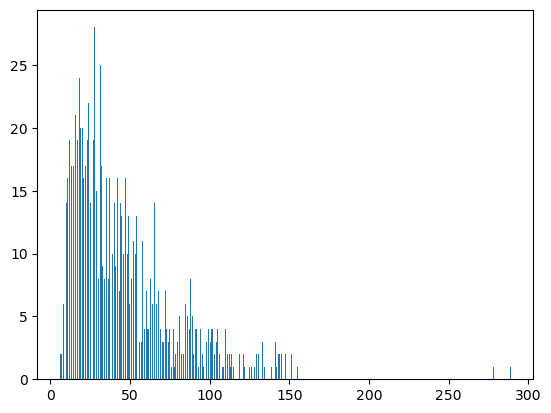

In [259]:
plt.hist(dataX[dataX.columns[6]],bins=500)
plt.show()

## Preprocessing Part
Implement the kNN algorithm to impute the missing value

In [690]:
def kneighbors(k, rowsWithNum,df_rescale, df):
    indices = {}
    df_withNun = df.loc[rowsWithNum].apply(minmax_scale)
    for row in rowsWithNum:
        distances = np.sqrt(((df_rescale - df_withNun.loc[row]) ** 2).sum(axis=1))
        indices.update( {row:distances.sort_values()[:k].index})
    return indices

def knn_imputation(df, k=5):
    df_imputed = df.copy()
    df_withoutNun = df[~df.isnull().any(axis=1)]
    df_rescale = df_withoutNun.apply(minmax_scale)
    for feature in tqdm.tqdm(df.columns,position=0,leave=True):
        rowsWithNum = df[df[feature].isnull()].index
        indices = kneighbors(k,rowsWithNum,df_rescale,df)
        for key in indices:
            imputed = df.loc[indices[key],feature].mean().round(2)
            df_imputed[feature].iloc[[key]] = imputed

    return df_imputed

dataX_imputed = knn_imputation(dataX)

100%|██████████| 11/11 [00:00<00:00, 21.42it/s]


In [691]:
dataY_outlier = dataY[(np.abs(stats.zscore(dataX_imputed)) < 3).all(axis=1)]
dataX_outlier = dataX_imputed[(np.abs(stats.zscore(dataX_imputed)) < 3).all(axis=1)]
dataX_outlier.reset_index(drop=True,inplace=True)
dataY_outlier.reset_index(drop=True,inplace=True)

Using the Random Over Sample to deal with the imbalance data

In [640]:
ros = RandomOverSampler(sampling_strategy='auto')
X_ros, Y_ros = ros.fit_resample(dataX_outlier,dataY_outlier)

In [60]:
#SMOTE = SMOTE(sampling_strategy='auto')
X_res = pd.read_csv('X_res.csv')
X_res.drop(X_res.columns[0],axis=1, inplace = True)
Y_res = pd.read_csv('Y_res.csv')
Y_res.drop(Y_res.columns[0],axis=1, inplace = True)
Y_res.rename(columns={'class':'target'}, inplace = True)

## Building Tree
### First version
First define the formula of entropy and information_gain.

In [693]:
def entropy(counts):
    # Calculate the entropy of the target variable
    n = sum(counts)
    ent = 0
    for count in counts:
        p = count / n
        ent -= p * math.log(p, 2)
    return ent
def information_gain(df,df_left, df_right):

    left_entropy = entropy(df_left.target.value_counts())
    right_entropy = entropy(df_right.target.value_counts())


    total_size = len(df_left) + len(df_right)
    left_weight = len(df_left) / total_size
    right_weight = len(df_right) / total_size
    weighted_avg_entropy = left_weight * left_entropy + right_weight * right_entropy


    parent_entropy = entropy(df.target.value_counts())
    info_gain = parent_entropy - weighted_avg_entropy

    return info_gain

Creat a Node as the root. And use the IG as the standard to choose the best feature and threshold to split the node
When the tree is reach the max_depth or min_samples_at_leaf or only remain less than 2 classes, stop and store the target in the node.

In [694]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, target=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.target = target

def create_tree(df, max_depth=5, min_samples_at_leaf=5):
    if len(df.target.unique()) <= 2 or max_depth == 0:
        return Node(target=int(df.target.mode().loc[0]))
    else:
        features = df.columns[:-1]
        best_feature = None
        best_threshold = None
        best_gain = 0
        for feature in features:
            values = df[feature].unique()
            for value in values:
                if value == values.max():
                    threshold = values.max()
                else:
                    threshold = (value + values[values > value].min()) / 2
                df_left = df[df[feature] <= threshold]
                df_right = df[df[feature] > threshold]
                gain = information_gain(df,df_left, df_right)
                if gain > best_gain:
                    best_feature = feature
                    best_threshold = threshold
                    best_gain = gain
        df_left = df[df[best_feature] <= best_threshold]
        df_right = df[df[best_feature] > best_threshold]
        if len(df_left) < min_samples_at_leaf or len(df_right) < min_samples_at_leaf:
            return Node(target=int(df.target.mode().loc[0]))
        left = create_tree(df_left,max_depth=max_depth-1, min_samples_at_leaf=min_samples_at_leaf)
        right = create_tree(df_right,max_depth=max_depth-1, min_samples_at_leaf=min_samples_at_leaf)
        return Node(feature=best_feature, threshold = best_threshold, left=left, right=right)

In [695]:
X_train, X_val, y_train, y_val = train_test_split(dataX_outlier, dataY_outlier, test_size=0.2, stratify=dataY_outlier)
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
X_val.reset_index(drop=True,inplace=True)
y_val.reset_index(drop=True,inplace=True)

In [696]:
tree = create_tree(pd.concat([X_train, y_train], axis=1), max_depth=12, min_samples_at_leaf=3)

In [673]:
def predict(tree,x):
    while tree.target == None:
        feature = tree.feature
        threshold = tree.threshold
        if x[feature] <= threshold:
            tree = tree.left
        else:
            tree = tree.right
    return tree.target

def predictAns(tree, X):
    predictions = []
    for index in tqdm.trange(len(X)):
        predictions.append(predict(tree, X.loc[index]))
    return predictions

## Evaluate Part
make the prediction

In [697]:
pre = predictAns(tree,X_val)

In [457]:
def report(predictions, y_test):
    print('Accuracy: %s' % accuracy_score(y_test, predictions))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predictions,labels=[3,4,5,6,7,8]))
    print('Classification Report:')
    print(classification_report(y_test, predictions))

In [460]:
report(pre,y_val)

Accuracy: 0.5698924731182796
Confusion Matrix:
[[ 0  0  1  0  0  0]
 [ 0  0  4  2  0  0]
 [ 0  1 45 32  0  0]
 [ 0  4 16 52  5  0]
 [ 0  0  6  7  9  0]
 [ 0  0  2  0  0  0]]
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         6
           5       0.61      0.58      0.59        78
           6       0.56      0.68      0.61        77
           7       0.64      0.41      0.50        22
           8       0.00      0.00      0.00         2

    accuracy                           0.57       186
   macro avg       0.30      0.28      0.28       186
weighted avg       0.56      0.57      0.56       186



## Second version
Add boosting into the tree

Use this function to calculate the error base on the last weak learner

In [698]:
def predict(tree,x):
    while tree.target == None:
        feature = tree.feature
        threshold = tree.threshold
        if x[feature] <= threshold:
            tree = tree.left
        else:
            tree = tree.right
    return tree.target

def predictAns(tree, X):
    predictions = []
    for index in range(len(X)):
        predictions.append(predict(tree, X.loc[index]))
    return predictions

Use a function weight_sum to calculate the sum of weight of instances

In [707]:
def weight_sum(df):
    weight_dic = {3:0,4:0,5:0,6:0,7:0,8:0}
    for index in df.index:
        weight_dic[df.target[index]] += df.weights[index]
    for key in range(3,9):
        if weight_dic[key] == 0:
            weight_dic.pop(key)
    return weight_dic

def entropy(df):
    n = sum(df.weights)
    ent = 0
    weight_dic = weight_sum(df)
    for key in weight_dic:
        p = weight_dic[key] / n
        ent -=   p * math.log(p, 2)
    return ent

def information_gain(df, df_left, df_right):
    left_entropy = entropy(df_left)
    right_entropy = entropy(df_right)

    total_size = len(df_left) + len(df_right)

    left_weight = len(df_left) / total_size
    right_weight = len(df_right) / total_size

    weighted_avg_entropy = left_weight * left_entropy + right_weight * right_entropy
    parent_entropy = entropy(df)
    info_gain = parent_entropy - weighted_avg_entropy

    return info_gain


In [709]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, target=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.target = target

def create_tree(df, weights, max_depth=5, min_samples_at_leaf=5):
    if len(df.target.unique()) <= 2 or max_depth == 0:
        return Node(target=int(df.target.mode().loc[0]))
    else:
        df['weights'] = weights[df.index]
        features = df.columns[:-2]
        best_feature = None
        best_threshold = None
        best_gain = 0
        for feature in features:
            values = df[feature].unique()
            for value in values:
                if value == values.max():
                    threshold = values.max()
                else:
                    threshold = (value + values[values > value].min()) / 2
                df_left = df[df[feature] <= threshold]
                df_right = df[df[feature] > threshold]
                gain = information_gain(df,df_left, df_right)
                if gain > best_gain:
                    best_feature = feature
                    best_threshold = threshold
                    best_gain = gain
        df_left = df[df[best_feature] <= best_threshold]
        df_right = df[df[best_feature] > best_threshold]
        if len(df_left) < min_samples_at_leaf or len(df_right) < min_samples_at_leaf:
            return Node(target=int(df.target.mode().loc[0]))
        left = create_tree(df_left, weights, max_depth=max_depth-1, min_samples_at_leaf=min_samples_at_leaf)
        right = create_tree(df_right, weights, max_depth=max_depth-1, min_samples_at_leaf=min_samples_at_leaf)
        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)


Calculate the error to update the weight

In [710]:
def boost(X, y, num_iterations=50):
    example_weights = np.ones(len(y)) / len(y)
    weak_learners = []
    for i in tqdm.trange(num_iterations,position=0,leave=True):
        tree = create_tree(pd.concat([X, y], axis=1),weights=example_weights, max_depth=12, min_samples_at_leaf=3)
        prediction = predictAns(tree, X)
        error = np.average(prediction != np.array(y.target), weights=example_weights)
        if error >= 0.5:
            break
        beta = error / (1 - error)
        for index in range(len(example_weights)):
            if prediction[index] == y.target.loc[index]:
                example_weights[index] *= beta
        example_weights /= np.sum(example_weights)
        weak_learners.append((beta, tree))
    return weak_learners


To predict the final answer. The instance with higest weighted vote is the target value

In [711]:
def strong_learner_preadict(weak_learners,x):
    weight_dic = {3:0,4:0,5:0,6:0,7:0,8:0}
    for beta,tree in weak_learners:
        pre = predict(tree,x)
        weight_dic[pre] += np.log(1/beta)
    max=0
    target = None
    for key in weight_dic:
        if weight_dic[key] > max:
            max = weight_dic[key]
            target = key
    return target

def SL_preadictAns(weak_learners,x):
    predictions = []
    for index in tqdm.trange(len(x),position=0,leave=True):
        predictions.append(strong_learner_preadict(weak_learners, x.loc[index]))
    return predictions

In [720]:
X_train, X_val, y_train, y_val = train_test_split(dataX_outlier, dataY_outlier, test_size=0.2, stratify=dataY_outlier)
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
X_val.reset_index(drop=True,inplace=True)
y_val.reset_index(drop=True,inplace=True)
dataY_outlier.reset_index(drop=True,inplace=True)
weak_learners = boost(X_train, y_train,num_iterations=11)

 36%|███▋      | 4/11 [06:49<11:57, 102.47s/it]


In [727]:
pre2 = SL_preadictAns(weak_learners,X_val)

100%|██████████| 186/186 [00:00<00:00, 5078.94it/s]


In [717]:
def report(predictions, y_test):
    print('Accuracy: %s' % accuracy_score(y_test, predictions))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predictions,labels=[3,4,5,6,7,8]))
    print('Classification Report:')
    print(classification_report(y_test, predictions))

In [728]:
report(pre2,y_val)

Accuracy: 0.7849462365591398
Confusion Matrix:
[[ 1  0  0  0  0  0]
 [ 0  3  3  0  0  0]
 [ 0  0 66 12  0  0]
 [ 0  0 14 60  3  0]
 [ 0  2  0  4 16  0]
 [ 0  0  0  2  0  0]]
Classification Report:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         1
           4       0.60      0.50      0.55         6
           5       0.80      0.85      0.82        78
           6       0.77      0.78      0.77        77
           7       0.84      0.73      0.78        22
           8       0.00      0.00      0.00         2

    accuracy                           0.78       186
   macro avg       0.67      0.64      0.65       186
weighted avg       0.78      0.78      0.78       186



Predict the test dataset and save as csv file

In [714]:
dataTest = pd.read_excel('MLdata/Dataset1_test/X_test.xlsx')
dataTest = knn_imputation(dataTest)
d1ans = SL_preadictAns(bestModel,dataTest)
ans=pd.DataFrame(columns=["index","target"])
for i,pre in enumerate(d1ans):
    ans.loc[i] = [i,int(pre)]
ans.to_csv("d1ans.csv",index=False)

100%|██████████| 256/256 [00:00<00:00, 5981.75it/s]


# Dataset 2

In [734]:
def entropy(counts):
    # Calculate the entropy of the target variable
    n = sum(counts)
    ent = 0
    for count in counts:
        p = count / n
        ent -= p * math.log(p, 2)
    return ent
def information_gain(df,df_left, df_right):

    left_entropy = entropy(df_left.target.value_counts())
    right_entropy = entropy(df_right.target.value_counts())


    total_size = len(df_left) + len(df_right)
    left_weight = len(df_left) / total_size
    right_weight = len(df_right) / total_size
    weighted_avg_entropy = left_weight * left_entropy + right_weight * right_entropy


    parent_entropy = entropy(df.target.value_counts())
    info_gain = parent_entropy - weighted_avg_entropy

    return info_gain

In [735]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, target=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.target = target

def create_tree(df, max_depth=5, min_samples_at_leaf=5):
    if len(df.target.unique()) <= 2 or max_depth == 0:
        return Node(target=int(df.target.mode().loc[0]))
    else:
        features = df.columns[:-1]
        best_feature = None
        best_threshold = None
        best_gain = 0
        for feature in features:
            values = df[feature].unique()
            num_values = round(len(values)**(1/3)**2)
            min = np.min(values)
            max = np.max(values)
            interval = (max - min + 1)/num_values
            values = [round(min + i*interval,2) for i in range(num_values)]
            for value in values:
                # if value == max:
                #     threshold = values.max()
                # else:
                #     threshold = (value + values[values > value].min()) / 2
                threshold = value
                df_left = df[df[feature] <= threshold]
                df_right = df[df[feature] > threshold]
                gain = information_gain(df,df_left, df_right)
                if gain > best_gain:
                    best_feature = feature
                    best_threshold = threshold
                    best_gain = gain
        if best_feature==None:
            df.to_csv('temp.csv')
            # print(df.value_counts())
            # print(df)
            # print(df.target.unique())
            return Node(target=int(df.target.mode().loc[0]))
        df_left = df[df[best_feature] <= best_threshold]
        df_right = df[df[best_feature] > best_threshold]
        if len(df_left) < min_samples_at_leaf or len(df_right) < min_samples_at_leaf:
            return Node(target=int(df.target.mode().loc[0]))
        left = create_tree(df_left,max_depth=max_depth-1, min_samples_at_leaf=min_samples_at_leaf)
        right = create_tree(df_right,max_depth=max_depth-1, min_samples_at_leaf=min_samples_at_leaf)
        return Node(feature=best_feature, threshold = best_threshold, left=left, right=right)

In [736]:
def predict(tree,x):

    while tree.target == None:
        feature = tree.feature
        threshold = tree.threshold
        if x[feature] <= threshold:
            tree = tree.left
        else:
            tree = tree.right
    return tree.target

def predictAns(tree, X):
    predictions = []
    for index in tqdm.trange(len(X)):
        predictions.append(predict(tree, X.loc[index]))
    return predictions

In [737]:
dataX = pd.read_excel("MLdata/Dataset2_train/X_train.xlsx")
dataY = pd.read_excel("MLdata/Dataset2_train/y_train.xlsx")
processing_function_list = [to_lower,
                            remove_itemized_bullet_and_numbering,
                            remove_punctuation,
                            remove_whitespace,
                            normalize_unicode,
                            remove_stopword,
                            substitute_token,
                            lemmatize_word]
dataX = [str(x) for x in dataX.Phrase]
dataX = [preprocess_text(x,processing_function_list) for x in tqdm.tqdm(dataX,position=0,leave=True)]
vectoriser = TfidfVectorizer(max_features=7000)
dataX = vectoriser.fit_transform(dataX)
dataX = pd.DataFrame(dataX.toarray(),columns=vectoriser.get_feature_names())
X_train, X_val, y_train, y_val = train_test_split(dataX, dataY, test_size=0.2, stratify=dataY)
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
X_val.reset_index(drop=True,inplace=True)
y_val.reset_index(drop=True,inplace=True)
dataY_outlier.reset_index(drop=True,inplace=True)

100%|██████████| 124848/124848 [00:34<00:00, 3605.32it/s]


In [ ]:
tree = create_tree(pd.concat([X_train, y_train], axis=1), max_depth=12, min_samples_at_leaf=3)

In [629]:
def report(predictions, y_test):
    print('Accuracy: %s' % accuracy_score(y_test, predictions))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predictions,labels=[0,1,2,3,4]))
    print('Classification Report:')
    print(classification_report(y_test, predictions))

In [626]:
pre = predictAns(tree,X_val)

100%|██████████| 30865/30865 [00:01<00:00, 19076.12it/s]


In [630]:
report(pre,y_val)

Accuracy: 0.5050704681678276
Confusion Matrix:
[[    0     0  1414     0     0]
 [    0     0  5448     0     0]
 [    0     0 15589     0     0]
 [    0     0  6573     0     0]
 [    0     0  1841     0     0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1414
           1       0.00      0.00      0.00      5448
           2       0.51      1.00      0.67     15589
           3       0.00      0.00      0.00      6573
           4       0.00      0.00      0.00      1841

    accuracy                           0.51     30865
   macro avg       0.10      0.20      0.13     30865
weighted avg       0.26      0.51      0.34     30865



In [110]:
dataTest = pd.read_excel('MLdata/Dataset2_test/X_test.xlsx')
dataTest = knn_imputation(dataTest)
d2ans = predictAns(tree,dataTest)
ans=pd.DataFrame(columns=["index","Sentiment])
for i,pre in enumerate(d2ans):
    ans.loc[i] = [i,int(pre)]
ans.to_csv("d2ans.csv",index=False)

  0%|          | 0/11 [00:00<?, ?it/s]/Users/chc/opt/anaconda3/envs/NLP/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/chc/opt/anaconda3/envs/NLP/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/var/folders/5x/dbx2lv556_g0h2jsjg7k_tf00000gn/T/ipykernel_8228/1232496976.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  indices.update( {row:distances.sort_values()[:k].index})
/Users/chc/opt/anaconda3/envs/NLP/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0